In [20]:
# Copyright (c) Sebastian Raschka under Apache License 2.0 (see LICENSE.txt).
# Source for "Build a Large Language Model From Scratch"
#   - https://www.manning.com/books/build-a-large-language-model-from-scratch
# Code: https://github.com/rasbt/LLMs-from-scratch
#
# 7장의 코드를 기반으로 한 최소한의 Instruction Finetuning 예제 파일

from functools import partial
from importlib.metadata import version
import json
import os
import re
import time

import matplotlib.pyplot as plt
import requests
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 로컬 파일(이전 챕터에서 작성된 유틸리티 함수들)에서 필요한 모듈 임포트
# GPTModel 구조, 생성 함수, 학습 루프 함수 등을 가져옵니다.
from previous_chapters import (
    calc_loss_loader,
    generate,
    GPTModel,
    text_to_token_ids,
    train_model_simple,
    token_ids_to_text,
    load_gpt2_model
)

class InstructionDataset(Dataset):
    """
    지시사항(Instruction) 데이터셋을 처리하는 PyTorch Dataset 클래스.
    입력 데이터(지시+입력)와 정답 데이터(응답)를 하나의 텍스트로 합쳐서 토큰화합니다.
    """
    def __init__(self, data, tokenizer):
        self.data = data

        # 텍스트 데이터 미리 토큰화 (Pre-tokenize)
        self.encoded_texts = []
        for entry in data:
            # 포맷팅 함수를 이용해 "지시사항 + 입력" 텍스트 생성
            instruction_plus_input = format_input(entry)
            # 정답(Response) 텍스트 생성
            response_text = f"\n\n### Response:\n{entry['output']}"
            
            # 모델은 이 전체 텍스트(질문+답변)를 보고 다음 토큰을 예측하도록 학습됨
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)


def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    """
    데이터 로더에서 배치를 만들 때 사용하는 커스텀 함수.
    가변 길이의 시퀀스를 배치의 최대 길이에 맞춰 패딩(padding)하고, 
    정답(target) 데이터에서 패딩 부분은 손실(loss) 계산에서 제외하도록 처리합니다.
    """
    # 배치 내에서 가장 긴 시퀀스 길이 계산 (패딩을 위해 +1 여유)
    batch_max_length = max(len(item)+1 for item in batch)

    # 입력(inputs)과 정답(targets) 리스트 준비
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # 문장 끝 토큰 <|endoftext|> 추가
        new_item += [pad_token_id]
        
        # 가장 긴 길이에 맞춰 패딩 추가
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        
        # 입력은 마지막 토큰 제외 (0 ~ n-1)
        inputs = torch.tensor(padded[:-1]) 
        # 정답은 첫 번째 토큰 제외 (1 ~ n) -> 다음 토큰 예측 문제이므로
        targets = torch.tensor(padded[1:]) 

        # 중요: 패딩 부분 마스킹 처리
        # 타겟에서 패딩 토큰인 부분은 ignore_index(-100)로 바꿔서 CrossEntropyLoss 계산 시 무시되게 함
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        
        # 패딩이 시작되는 지점 이후의 모든 타겟 값을 -100으로 설정
        # region [패딩 마스킹 처리]
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        # endregion
        
        # 선택적으로 최대 시퀀스 길이 제한 (메모리 관리 등 목적)
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # 텐서로 변환 및 디바이스(GPU/CPU)로 이동
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor


def download_and_load_file(file_path, url):
    """
    데이터 파일이 없으면 다운로드하고, JSON 형태로 로드하는 유틸리티 함수
    """
    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


def format_input(entry):
    """
    Alpaca 스타일의 프롬프트 템플릿을 적용하는 함수.
    모델에게 역할을 부여하고 입력 형식을 통일합니다.
    """
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    # 추가적인 입력 정보(Context 등)가 있는 경우 추가
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    """
    학습 진행 상황(Loss)을 그래프로 시각화하여 PDF로 저장하는 함수
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 에폭(Epoch) 기준 Loss 그래프
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # 처리한 토큰 수(Tokens seen) 기준 보조 x축 생성
    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) 
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plot_name = "outputs/loss-plot-standalone.pdf"
    print(f"Plot saved as {plot_name}")
    plt.savefig(plot_name)
    # plt.show()


def main(test_mode=False):
    #######################################
    # 패키지 버전 출력 (디버깅용)
    #######################################
    print()
    pkgs = [
        "matplotlib",  # 시각화
        "tiktoken",    # 토크나이저
        "torch",       # 딥러닝 프레임워크
        "tqdm",        # 진행률 표시 바
    ]
    for p in pkgs:
        print(f"{p} version: {version(p)}")
    print(50*"-")

    #######################################
    # 1. 데이터셋 다운로드 및 준비
    #######################################
    file_path = "datas/instruction-data.json"
    url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"
    data = download_and_load_file(file_path, url)

    # 데이터 분할 (Train 85% / Test 10% / Valid 5%)
    train_portion = int(len(data) * 0.85) 
    test_portion = int(len(data) * 0.1)   

    train_data = data[:train_portion]
    test_data = data[train_portion:train_portion + test_portion]
    val_data = data[train_portion + test_portion:]

    # 테스트 모드일 경우 아주 적은 데이터만 사용 (빠른 실행 확인용)
    if test_mode:
        train_data = train_data[:10]
        val_data = val_data[:10]
        test_data = test_data[:10]

    print("Training set length:", len(train_data))
    print("Validation set length:", len(val_data))
    print("Test set length:", len(test_data))
    print(50*"-")

    # 토크나이저 및 디바이스 설정
    tokenizer = tiktoken.get_encoding("gpt2")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)
    print(50*"-")

    # 커스텀 collate 함수 설정 (partial을 사용해 고정 인자 전달)
    customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

    num_workers = 0
    batch_size = 8
    torch.manual_seed(123)

    # 학습용 데이터 로더
    train_dataset = InstructionDataset(train_data, tokenizer)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        collate_fn=customized_collate_fn, # 커스텀 배치 처리 함수 사용
        shuffle=True,
        drop_last=True,
        num_workers=num_workers
    )

    # 검증용 데이터 로더
    val_dataset = InstructionDataset(val_data, tokenizer)
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        collate_fn=customized_collate_fn,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers
    )

    #######################################
    # 2. 사전 학습된 모델 로드 (Pre-trained Model)
    #######################################

    if test_mode:
        # 테스트 모드용 초소형 더미 모델
        BASE_CONFIG = {
            "vocab_size": 50257,
            "context_length": 120,
            "drop_rate": 0.0,
            "qkv_bias": False,
            "emb_dim": 12,
            "n_layers": 1,
            "n_heads": 2
        }
        model = GPTModel(BASE_CONFIG)
        model.eval()
        device = "cpu"
        CHOOSE_MODEL = "Small test model"

    else:
        # 실제 학습용 설정: GPT-2 Medium (355M)
        BASE_CONFIG = {
            "vocab_size": 50257,     
            "context_length": 1024,  
            "drop_rate": 0.0,        
            "qkv_bias": True         
        }

        model_configs = {
            "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
            "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
            "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
            "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
        }

        CHOOSE_MODEL = "gpt2-medium (355M)"
        BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

        # 로컬에 저장된 모델 가중치 파일 로드
        model_name = "gpt2-medium-355M.pth"
        model = load_gpt2_model(model_name, BASE_CONFIG)

        model.eval()
        model.to(device)

    print("Loaded model:", CHOOSE_MODEL)
    print(50*"-")

    #######################################
    # 3. 모델 미세 조정 (Finetuning)
    #######################################
    print("Initial losses")
    # 학습 전 초기 손실값 확인
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

    print("   Training loss:", train_loss)
    print("   Validation loss:", val_loss)

    start_time = time.time()
    # 옵티마이저 설정 (AdamW)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

    num_epochs = 2

    torch.manual_seed(123)
    
    # 실제 학습 수행 (previous_chapters.py에 정의된 함수 사용)
    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=5, eval_iter=5,
        start_context=format_input(val_data[0]), tokenizer=tokenizer
    )

    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    # 학습 결과 시각화
    epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
    plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
    print(50*"-")

    #######################################
    # 4. 결과 저장 및 테스트
    #######################################
    print("Generating responses")
    # 테스트 데이터셋에 대해 모델 응답 생성
    for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

        input_text = format_input(entry)

        # 모델 생성 (Inference)
        token_ids = generate(
            model=model,
            idx=text_to_token_ids(input_text, tokenizer).to(device),
            max_new_tokens=256,
            context_size=BASE_CONFIG["context_length"],
            eos_id=50256
        )
        generated_text = token_ids_to_text(token_ids, tokenizer)
        
        # 프롬프트 부분을 제거하고 응답 부분만 추출
        response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

        test_data[i]["model_response"] = response_text

    # 생성된 응답을 포함하여 JSON 파일로 저S장
    test_data_path = "outputs/instruction-data-with-response-standalone.json"
    with open(test_data_path, "w") as file:
        json.dump(test_data, file, indent=4) 
    print(f"Responses saved as {test_data_path}")

    # 미세 조정된 모델 가중치 저장
    file_name = f"outputs/{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft-standalone.pth"
    torch.save(model.state_dict(), file_name)
    print(f"Model saved as {file_name}")



matplotlib version: 3.10.0
tiktoken version: 0.12.0
torch version: 2.9.0+cu126
tqdm version: 4.67.1
--------------------------------------------------
Training set length: 935
Validation set length: 55
Test set length: 110
--------------------------------------------------
Device: cuda
--------------------------------------------------
Downloaded to ./models/gpt2/gpt2-medium-355M.pth
Loaded model: gpt2-medium (355M)
--------------------------------------------------
Initial losses
   Training loss: 3.8390544414520265
   Validation loss: 3.7619347095489504
Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 00

100%|██████████| 110/110 [01:11<00:00,  1.55it/s]


Responses saved as outputs/instruction-data-with-response-standalone.json
Model saved as outputs/gpt2-medium355M-sft-standalone.pth


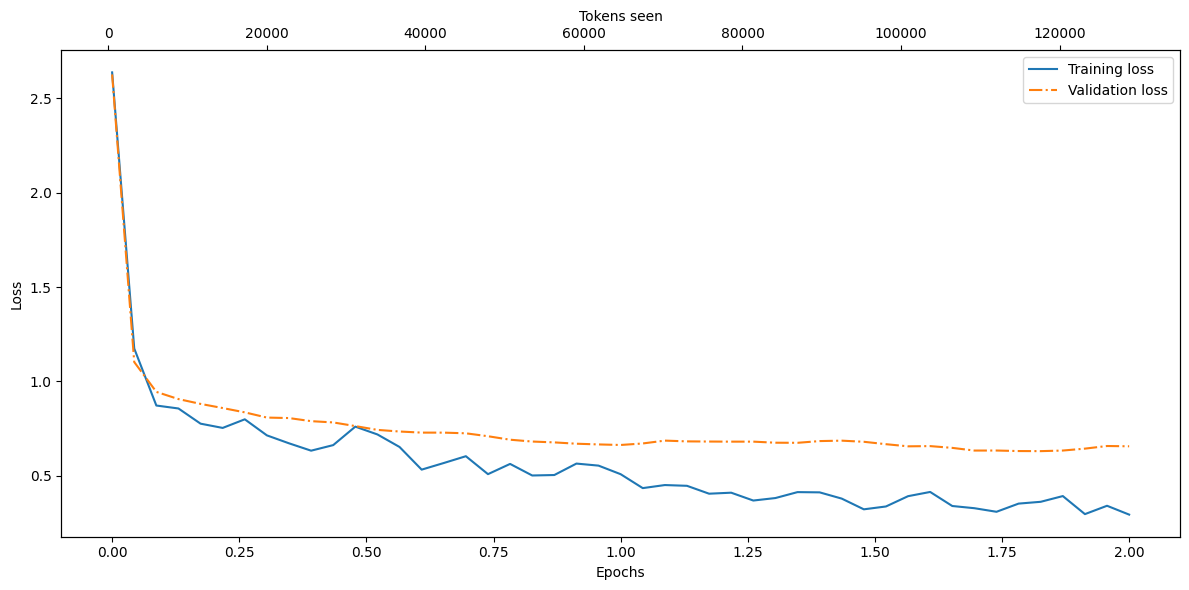

In [21]:
main(test_mode=False)